### If you're using your own machine, install qiskit first
To do that, uncomment the line below and run cell

In [1]:
# !pip install qiskit==0.43.0
# !pip install qiskit-aer==0.12.0
# !pip install networkx
# !pip install matplotlib

### And check version — should match the one below

### Let's solve MAXCUT on a simple graph

Recall the MAXCUT objective is $\max_{\mathbb{s}}\frac{1}{2}\sum_{ij\in E}(1-s_is_j)$

Before going further, let's reformulate it:

$\frac{1}{2}\sum_{ij\in E}(1-s_is_j) = \frac{1}{2}\sum_{ij\in E}(-s_is_j) + const$

Therefore the above _maximization_ problem is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

### Constructing the Hamiltonian

MAXCUT is equivalent to the problem below:

$\max_{\mathbb{s}}\sum_{ij\in E}(-s_is_j)$

We've seen earlier that the Hamiltonian can be constructed by mapping binary variables $s_i$ onto the eigenvalues of $Z$. For the above maximization problem has the following Hamiltonian:

$\sum_{ij\in E}(-Z_iZ_j)$

### Constructing QAOA circuit

Cost Hamiltonian: $C = \sum_{ij\in E}(-Z_iZ_j)$

The full QAOA circuit:

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

Need to implement cost operator $e^{-i\gamma_p C}$ and mixer operator $e^{-i\beta_p B}$

### Let's beging by importing everything we'll need later

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer

### Consider the following graph

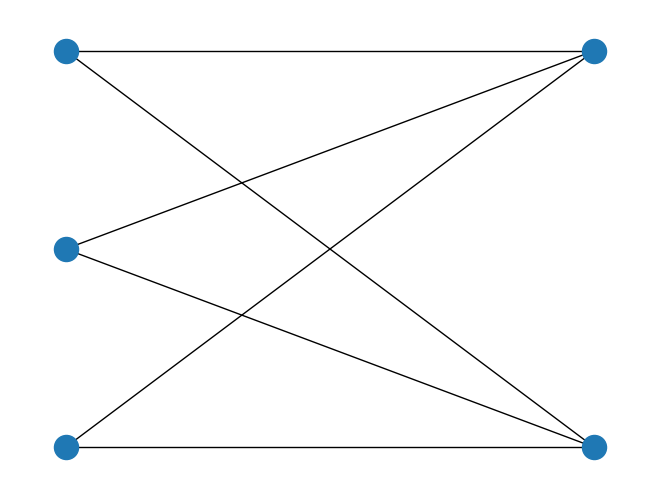

In [3]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, pos=nx.bipartite_layout(G, [0,1,2]))

### We can now build the circuit for cost operator

Cost operator $ e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$

Note that later we will see how to do this more efficiently in Qiskit

In [4]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def append_cost_operator_circuit(qc, G, gamma):
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    

### Let's verify that our function produces the correct circuit

Cost operator $e^{-i\gamma_p C} = e^{-i\gamma_p \sum_{ij\in E}(-Z_iZ_j)}$

In [5]:
N = G.number_of_nodes()
qc = QuantumCircuit(N)
append_cost_operator_circuit(qc, G, np.pi / 3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────────────────■─────────────────»
       │                │    │     ┌───┐    ┌──────────┐  │  ┌───┐     ┌───┐»
q_1: ──┼────────────────┼────┼─────┤ X ├────┤ Rz(2π/3) ├──┼──┤ X ├─────┤ X ├»
       │                │    │     └─┬─┘    └──────────┘  │  └─┬─┘┌───┐└─┬─┘»
q_2: ──┼────────────────┼────┼───────┼────────────────────┼────┼──┤ X ├──┼──»
     ┌─┴─┐┌──────────┐┌─┴─┐  │       │                    │    │  └─┬─┘  │  »
q_3: ┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■────────────────────┼────■────■────┼──»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐            ┌─┴─┐            │  »
q_4: ──────────────────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├────────────■──»
                           └───┘└──────────┘            └───┘               »
«                                                 
«q_0: ────────────────────────────────────────────
«     ┌──────────┐     ┌───┐                      
«q_1: ┤ Rz(2π/3) ├─────┤ X ├──────────────────────
«     ├──────────┤┌───┐└─┬─┘┌───┐┌──────────┐┌───┐
«q_2: ┤ Rz(2π/3) ├┤ X ├──┼──┤ X ├┤ Rz(2π/3) ├┤ X ├
«     └──────────┘└─┬─┘  │  └─┬─┘└──────────┘└─┬─┘
«q_3: ──────────────■────┼────┼────────────────┼──
«                        │    │                │  
«q_4: ───────────────────■────■────────────────■──
«

### Now we need to build mixer operator

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}$

In [6]:
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def append_mixer_operator_circuit(qc, G, beta):
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc


### Let's verify the circuit

Mixer operator: $e^{-i\beta_p B} = e^{-i\beta_p \sum_{i\in V}X_i} = e^{-i\beta_p X_0}e^{-i\beta_p X_1}e^{-i\beta_p X_2}e^{-i\beta_p X_3}e^{-i\beta_p X_4}$

In [7]:
N = G.number_of_nodes()
qc = QuantumCircuit(N)
append_mixer_operator_circuit(qc, G, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ Rx(2π/3) ├
     ├──────────┤
q_1: ┤ Rx(2π/3) ├
     ├──────────┤
q_2: ┤ Rx(2π/3) ├
     ├──────────┤
q_3: ┤ Rx(2π/3) ├
     ├──────────┤
q_4: ┤ Rx(2π/3) ├
     └──────────┘

### Now we are ready to build the full circuit

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [8]:
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        append_cost_operator_circuit(qc, G, beta[i])
        append_mixer_operator_circuit(qc, G, gamma[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc

### Let's verify that circuit looks right

$|\psi{(\mathbb{\beta},\mathbb{\gamma})}> =  e^{-i\beta_p B}e^{-i\gamma_p C}\cdots e^{-i\beta_1 B}e^{-i\gamma_1 C} H^{\otimes n} |0>$

In [9]:
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])
qc.draw()

┌───┐                                                        ┌───────┐»
q_0: ┤ H ├──■────────────────■────■────────────────────────────■──┤ Rx(π) ├»
     ├───┤  │                │    │     ┌───┐    ┌──────────┐  │  └─┬───┬─┘»
q_1: ┤ H ├──┼────────────────┼────┼─────┤ X ├────┤ Rz(2π/3) ├──┼────┤ X ├──»
     ├───┤  │                │    │     └─┬─┘    └──────────┘  │    └─┬─┘  »
q_2: ┤ H ├──┼────────────────┼────┼───────┼────────────────────┼──────┼────»
     ├───┤┌─┴─┐┌──────────┐┌─┴─┐  │       │                    │      │    »
q_3: ┤ H ├┤ X ├┤ Rz(2π/3) ├┤ X ├──┼───────■────────────────────┼──────■────»
     ├───┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐            ┌─┴─┐         »
q_4: ┤ H ├──────────────────────┤ X ├┤ Rz(2π/3) ├────────────┤ X ├─────────»
     └───┘                      └───┘└──────────┘            └───┘         »
c: 5/══════════════════════════════════════════════════════════════════════»
                                                                           »
«                                                                         ░ ┌─┐»
«q_0: ────────────────────────────────────────────────────────────────────░─┤M├»
«          ┌───┐┌──────────┐     ┌───┐┌───────┐                           ░ └╥┘»
«q_1: ─────┤ X ├┤ Rz(2π/3) ├─────┤ X ├┤ Rx(π) ├───────────────────────────░──╫─»
«     ┌───┐└─┬─┘├──────────┤┌───┐└─┬─┘└─┬───┬─┘┌──────────┐┌───┐┌───────┐ ░  ║ »
«q_2: ┤ X ├──┼──┤ Rz(2π/3) ├┤ X ├──┼────┤ X ├──┤ Rz(2π/3) ├┤ X ├┤ Rx(π) ├─░──╫─»
«     └─┬─┘  │  └──────────┘└─┬─┘  │    └─┬─┘  └┬───────┬─┘└─┬─┘└───────┘ ░  ║ »
«q_3: ──■────┼────────────────■────┼──────┼─────┤ Rx(π) ├────┼────────────░──╫─»
«            │                     │      │     └───────┘    │  ┌───────┐ ░  ║ »
«q_4: ───────■─────────────────────■──────■──────────────────■──┤ Rx(π) ├─░──╫─»
«                                                               └───────┘ ░  ║ »
«c: 5/═══════════════════════════════════════════════════════════════════════╩═»
«                                                                            0 »
«                 
«q_0: ────────────
«     ┌─┐         
«q_1: ┤M├─────────
«     └╥┘┌─┐      
«q_2: ─╫─┤M├──────
«      ║ └╥┘┌─┐   
«q_3: ─╫──╫─┤M├───
«      ║  ║ └╥┘┌─┐
«q_4: ─╫──╫──╫─┤M├
«      ║  ║  ║ └╥┘
«c: 5/═╩══╩══╩══╩═
«      1  2  3  4

### Running a circuit in Qiskit

For the purposes of this tutorial, we will be running the circuits in simulator. To run your circuits on real IBM quantum computers, all you need to do is change the backend. However, the devices are noisy, so there might be dragons!

#### Qiskit qubit ordering

Note that Qiskit uses an ordering where zeroth qubit is the rightmost (the least significant bit in the bistring),
so we need to invert the samples we received

In [10]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

Now we can run the circuit

In [11]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'10010': 21, '00010': 28, '10011': 35, '11100': 26, '01100': 27, '10000': 31, '11001': 36, '01110': 36, '00000': 34, '00100': 29, '11110': 32, '01010': 33, '10101': 32, '10110': 36, '00001': 25, '01101': 37, '11101': 31, '00111': 39, '00110': 32, '00101': 35, '11111': 38, '00011': 26, '10111': 32, '01011': 40, '11010': 37, '01001': 37, '01000': 28, '10100': 28, '11011': 33, '01111': 29, '10001': 34, '11000': 27}


### How good were these results?

To answer that, we need to compute $<\psi|C|\psi>$. Luckily, C is a classical Hamiltonian, so we can do this easily. We are going to compute -1 times the value of the cut because by convention classical optimizers minimize (this will come up shortly).

In [12]:
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

maxcut_obj('00011', G)

-6

### Estimate energy from the sample

In [13]:
def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

compute_maxcut_energy(invert_counts(result.get_counts()), G)

-2.955078125

### Putting all the pieces together

As you remember, we run QAOA as a variational algorithm, so we will need a classical optimizer to optimize the parameters $\beta$, $\gamma$. We will use Constrained Optimization BY Linear Approximation (COBYLA) from `scipy.optimize`.

We need to wrap our circuit into a black-box objective function `f` that COBYLA could optimize. Note that by convention all optimizers perform _minimization_, so we had to put a minus sign in front of our objective earlier.

In [14]:
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

### Now we can run the optimizer to get optimal parameters!

In [15]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':500, 'disp': True})
res_sample

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.4140625
       x: [ 2.083e+00  2.048e+00  1.792e+00  1.564e+00  1.387e+00
            2.281e+00  5.962e+00  1.789e+00  3.563e+00  5.646e+00]
    nfev: 132
   maxcv: 0.0

   Normal return from subroutine COBYLA

   NFVALS =  132   F =-5.414062E+00    MAXCV = 0.000000E+00
   X = 2.082732E+00   2.048352E+00   1.791867E+00   1.564222E+00   1.386746E+00
       2.280742E+00   5.961937E+00   1.788801E+00   3.562738E+00   5.645833E+00


### To get the solution strings, let's run the circuit with optimal parameters

In [16]:
optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend).result().get_counts())
counts

{'10101': 1,
 '10000': 4,
 '10111': 6,
 '01011': 14,
 '00111': 13,
 '11010': 1,
 '00011': 448,
 '11011': 1,
 '01100': 22,
 '11100': 399,
 '11111': 31,
 '01000': 4,
 '10100': 12,
 '01111': 8,
 '00000': 24,
 '01110': 1,
 '10011': 16,
 '00100': 8,
 '11000': 11}

### How good are there results?

<BarContainer object of 5 artists>

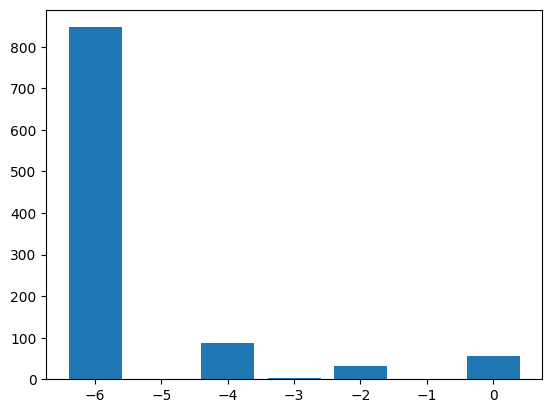

In [17]:
energies = defaultdict(int)
for k, v in counts.items():
    energies[maxcut_obj(k,G)] += v

x,y = zip(*energies.items())
plt.bar(x,y)

Pretty good! Most of the results we get correspond to good solutions!

Best string: 00011 with cut: 6


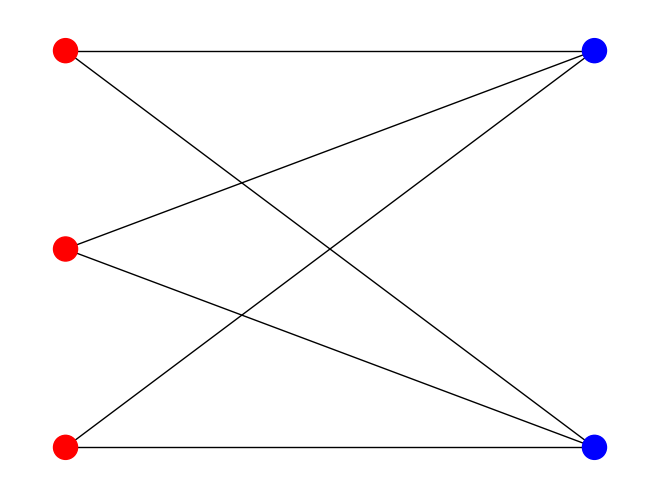

In [18]:
# get the best solution:
best_cut, best_solution = min([(maxcut_obj(x,G),x) for x in counts.keys()], key=itemgetter(0))
print(f"Best string: {best_solution} with cut: {-best_cut}")

# color the graph nodes by part
colors = ['r' if best_solution[node] == '0' else 'b' for node in G]
nx.draw(G,node_color = colors, pos=nx.bipartite_layout(G, [0,1,2]))

### Using statevector simulator

What if you want to get the full QAOA state? Luckily, Qiskit provides `statevector_simulator` backend. 

### What is a state vector?

State vector is a vector of amplitudes, e.g.: $\frac{1}{\sqrt{2}}\bigg(|00\rangle + |11\rangle\bigg) \rightarrow (\frac{1}{\sqrt{2}}, 0, 0, \frac{1}{\sqrt{2}})$

In [19]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
sv = execute(qc, backend=Aer.get_backend('statevector_simulator')).result().get_statevector()
sv

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


Less luckily, qubit ordering considerations still apply. Below are some helper functions we're going to use.

In [20]:
# Endianness conversion tools from https://github.com/Qiskit/qiskit-terra/issues/1148#issuecomment-438574708

import numpy as np

def state_num2str(basis_state_as_num, nqubits):
    return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

def state_str2num(basis_state_as_str):
    return int(basis_state_as_str, 2)

def state_reverse(basis_state_as_num, nqubits):
    basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
    new_str = basis_state_as_str[::-1]
    return state_str2num(new_str)

def get_adjusted_state(state):
    nqubits = np.log2(state.shape[0])
    if nqubits % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    nqubits = int(nqubits)

    adjusted_state = np.zeros(2**nqubits, dtype=complex)
    for basis_state in range(2**nqubits):
         adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
    return adjusted_state

### Running using full-state (`statevector`) simulator

Note that a few things are different when using the full statevector simulator. First, we must not measure. Second, as the result, we get amplitudes instead of samples.

In [21]:
def get_qaoa_circuit_sv(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        append_cost_operator_circuit(qc, G, beta[i])
        append_mixer_operator_circuit(qc, G, gamma[i])
    # no measurement in the end!
    return qc

Second, we need to get which amplitudes correspond to which computational basis states (= binary strings)

In [22]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts


Let's try plugging in the optimal parameters we found using the QASM simulator

In [23]:
backend = Aer.get_backend('statevector_simulator')
qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
sv = get_adjusted_state(np.asarray(execute(qc, backend).result().get_statevector()))
state_to_ampl_counts(sv)

{'00000': (-0.1598654615084961-0.028301102428443026j),
 '00001': (-0.014768325746808877+0.03229236295199232j),
 '00010': (-0.014768325746808836+0.03229236295199239j),
 '00011': (0.6129654578306006-0.18491057179816983j),
 '00100': (-0.02042166869551243+0.057926246387418195j),
 '00101': (0.016403301478893115+0.009926429804934418j),
 '00110': (0.01640330147889299+0.009926429804934397j),
 '00111': (-0.12424339245856489+0.021364691940825076j),
 '01000': (-0.02042166869551245+0.057926246387418195j),
 '01001': (0.01640330147889312+0.009926429804934418j),
 '01010': (0.016403301478893115+0.009926429804934418j),
 '01011': (-0.12424339245856483+0.02136469194082517j),
 '01100': (-0.12424339245856476+0.021364691940825065j),
 '01101': (0.016403301478893028+0.00992642980493437j),
 '01110': (0.016403301478892997+0.009926429804934366j),
 '01111': (-0.020421668695512336+0.05792624638741817j),
 '10000': (-0.020421668695512388+0.05792624638741829j),
 '10001': (0.016403301478893077+0.009926429804934396j),


### Let's verify that we get the same energy

In [24]:
def compute_maxcut_energy_sv(sv, G):
    """Compute objective from statevector
    For large number of qubits, this is slow. 
    """
    counts = state_to_ampl_counts(sv)
    return sum(maxcut_obj(np.array([int(x) for x in k]), G) * (np.abs(v)**2) for k, v in counts.items())

compute_maxcut_energy_sv(sv, G)

-5.374086179596247

Yay! Energy matches

### Now, we can run the full optimization loop with the statevector simulator

In [25]:
def get_black_box_objective_sv(G,p):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(G,beta, gamma)
        sv = np.asarray(execute(qc, backend).result().get_statevector())
        # return the energy
        return compute_maxcut_energy_sv(get_adjusted_state(sv), G)
    return f

Copying and pasting the code for the `qasm_simulator`...

In [26]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective_sv(G, p)

init_point = np.array([0.81069872, 2.2067517 , 0.83830696, 2.15579759, 0.37060699,
       2.42068091, 6.1575306 , 2.2453419 , 3.85060091, 6.137845  ])
# We are going to limit the number of iterations to 2500
res_sv = minimize(obj, init_point, method='COBYLA', options={'maxiter':500, 'disp': True})
res_sv

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -5.861346359050119
       x: [ 1.952e+00  2.117e+00  2.074e+00  1.437e+00  1.329e+00
            2.412e+00  5.933e+00  1.935e+00  3.622e+00  6.108e+00]
    nfev: 500
   maxcv: 0.0

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  500   F =-5.861346E+00    MAXCV = 0.000000E+00
   X = 1.951897E+00   2.116993E+00   2.074381E+00   1.436939E+00   1.328730E+00
       2.412478E+00   5.932600E+00   1.934828E+00   3.622118E+00   6.108096E+00


We get **much better solution** if we have access to the full state vector! In fact, if we run it long enough, we will get arbitratily close to the true optimum (to verify it yourself, try setting `'maxiter':10000` above)

In [27]:
print(f"Best energy with samples: {res_sample['fun']:.4f}, with full state vector: {res_sv['fun']:.4f}")

Best energy with samples: -5.4141, with full state vector: -5.8613


This is because with samples we get stuck in a lower quality point:

In [28]:
print(f"Angles found with samples: beta={res_sample['x'][:p]}, gamma={res_sample['x'][p:]}")
print(f"Angles found with full state: beta={res_sv['x'][:p]}, gamma={res_sv['x'][p:]}")

Angles found with samples: beta=[2.08273166 2.04835237 1.7918671  1.56422247 1.38674585], gamma=[2.28074179 5.96193669 1.78880073 3.56273794 5.64583346]
Angles found with full state: beta=[1.95189721 2.11699333 2.07438086 1.43693858 1.32873042], gamma=[2.41247847 5.93260003 1.93482762 3.62211802 6.10809619]


Note that these are two different points!

An important point to make is that this is **not a local minimum** that COBYLA gets stuck in when using the sampling. We can easily verify that by running COBYLA with full state from that point

In [29]:
# p is the number of QAOA alternating operators
p = 5
obj = get_black_box_objective_sv(G, p)

init_point = res_sample['x']
# 'rhobeg' controls initial changes to the variables. 
# We set it low to make sure we are searching a small neighborhood of the optimal point
res_sv2 = minimize(obj, init_point, method='COBYLA', options={'maxiter':50, 'disp': True, 'rhobeg': 0.01})
res_sv2


   Return from subroutine COBYLA because the MAXFUN limit has been reached.



 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -5.682038011414406
       x: [ 2.050e+00  2.077e+00  1.789e+00  1.598e+00  1.306e+00
            2.277e+00  6.078e+00  1.701e+00  3.574e+00  5.689e+00]
    nfev: 50
   maxcv: 0.0

   NFVALS =   50   F =-5.682038E+00    MAXCV = 0.000000E+00
   X = 2.049813E+00   2.077237E+00   1.789399E+00   1.597939E+00   1.306472E+00
       2.277215E+00   6.078025E+00   1.701412E+00   3.573566E+00   5.688632E+00


The lesson here is that our simple deterministic optimizers (like COBYLA) assume that *every function value they get is true*. This causes them to thing that a point is a local minimum, when in fact it is not. We have to bake the assumption of stochaisticity into the optimizers we use!